In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

# Carregar o CSV
df = pd.read_csv('MQD_1465_tratado.csv', sep=',', encoding='utf-8')

# Verificar o tamanho do arquivo e as primeiras linhas
print(df.shape)
print(df.head())

# Verificar as colunas disponíveis
print(df.columns)


(1465, 22)
   ItemNumber                                              frase cla_maj_femi  \
0           1  Você sabia que o menino que mais vai te dar va...     positiva   
1           2  Hoje com 21 anos, como que por auxilio lá do a...     positiva   
2           3  Nesse momento to evitando ela, e ta me dando u...     negativa   
3           4  Meus sentidos de garota diziam que tinha algum...       neutra   
4           5  Aquela promessa que eu te fiz naquele natal, e...     positiva   

   qtd_maj_femi cla_maj_masc  qtd_maj_masc  f1_class  f2_class  f3_class  \
0             4     positiva             4  positiva  positiva  positiva   
1             4     positiva             3  positiva  positiva  positiva   
2             3     negativa             2  negativa  negativa  negativa   
3             2       neutra             3    neutra  negativa    neutra   
4             3     positiva             3  positiva  positiva  negativa   

   f4_class  ...  m3_class  m4_class f1_tempo

In [ ]:
# Distribuição das classes majoritárias masculinas
print("Distribuição cla_maj_masc:")
print(df['cla_maj_masc'].value_counts(dropna=False))

# Distribuição das classes majoritárias femininas
print("\nDistribuição cla_maj_femi:")
print(df['cla_maj_femi'].value_counts(dropna=False))


Distribuição cla_maj_masc:
cla_maj_masc
positiva    619
negativa    514
neutra      332
Name: count, dtype: int64

Distribuição cla_maj_femi:
cla_maj_femi
positiva    514
negativa    503
neutra      448
Name: count, dtype: int64


In [ ]:
# Aplicando um crosstab para comparar as congruências entre gêneros
ct = pd.crosstab(df['cla_maj_masc'], df['cla_maj_femi'])
print("\nCrosstab das classes masculinas x femininas:")
print(ct)

#concordancia: 78,15%
#discordancia: 21,84%



Crosstab das classes masculinas x femininas:
cla_maj_femi  negativa  neutra  positiva
cla_maj_masc                            
negativa           435      65        14
neutra              36     253        43
positiva            32     130       457


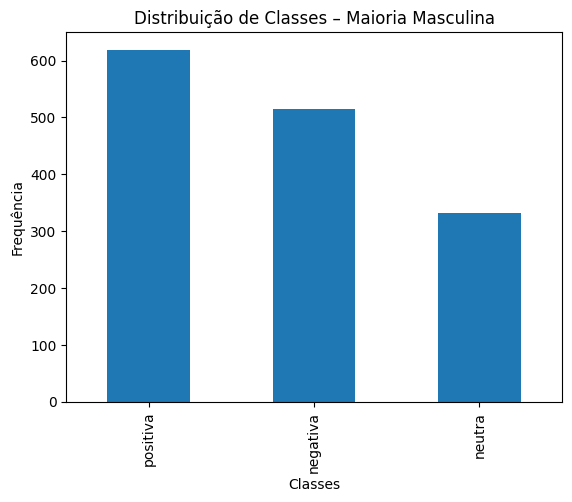

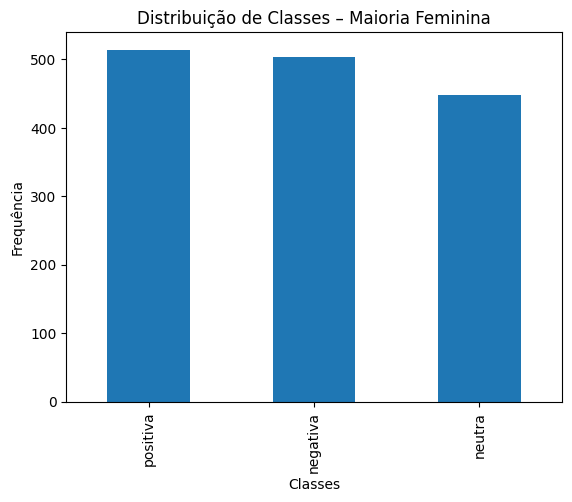

In [ ]:
# Plotando a distribuição das classes
df['cla_maj_masc'].value_counts().plot(kind='bar')
plt.title("Distribuição de Classes – Maioria Masculina")
plt.xlabel("Classes")
plt.ylabel("Frequência")
plt.show()

df['cla_maj_femi'].value_counts().plot(kind='bar')
plt.title("Distribuição de Classes – Maioria Feminina")
plt.xlabel("Classes")
plt.ylabel("Frequência")
plt.show()


In [ ]:
# Aplicaçao de um teste de independência (qui-quadrado)
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(ct)
print(f"Estatística qui-quadrado: {chi2}, p-valor: {p}")


Estatística qui-quadrado: 1348.6461779395033, p-valor: 9.434416363071011e-291


In [ ]:
# Calculo do Kappa de Fleiss
def fleiss_kappa(data_matrix):
    """
    Calcula o Kappa de Fleiss para uma matriz de contagens.
    Cada linha da matriz corresponde a um item,
    e cada coluna corresponde a uma categoria,
    contendo quantas vezes aquela categoria foi atribuída.

    Parâmetros
    ----------
    data_matrix : numpy.ndarray
        Matriz (itens x categorias).

    Retorno
    -------
    float
        Valor do Kappa de Fleiss.
    """
    N, k = data_matrix.shape  # N itens, k categorias
    n = np.sum(data_matrix[0])  # número de avaliadores por item (supõe-se o mesmo em todas as linhas)

    # P_i (índice de concordância) para cada item
    P_i = []
    for i in range(N):
        row = data_matrix[i, :]
        row_sum_sq = np.sum(row ** 2)
        # fórmula do P_i = (Σ(n_ij^2) - n) / [n * (n - 1)]
        P_i_item = (row_sum_sq - n) / (n * (n - 1))
        P_i.append(P_i_item)
    P_bar = np.mean(P_i)  # média dos P_i

    # p_j (proporção global de cada categoria j)
    p_j = np.sum(data_matrix, axis=0) / (N * n)  # soma por coluna / (N * n)
    P_bar_e = np.sum(p_j ** 2)  # soma dos quadrados das proporções

    # Kappa de Fleiss
    kappa = (P_bar - P_bar_e) / (1 - P_bar_e)
    return kappa


def compute_fleiss_kappa_for_raters(df, rater_cols, categories):
    """
    Converte as colunas de classificadores em uma matriz de contagens
    e calcula o Kappa de Fleiss.

    Parâmetros
    ----------
    df : pd.DataFrame
        DataFrame contendo as classificações.
    rater_cols : list
        Lista das colunas correspondentes aos avaliadores (e.g. ['f1_class','f2_class','m1_class','m2_class']).
    categories : list
        Lista de categorias possíveis (e.g. ['Positivo', 'Negativo', 'Neutro']).

    Retorno
    -------
    float
        Kappa de Fleiss para as colunas informadas.
    """
    # Se houver valores ausentes (NaN) em alguma das colunas de rater, podemos removê-los:
    df_valid = df.dropna(subset=rater_cols).copy()

    # Criar uma matriz (itens x categorias) com contagens de quantos avaliadores deram determinada categoria
    N = df_valid.shape[0]           # número de itens (linhas)
    k = len(rater_cols)             # número de avaliadores
    c = len(categories)             # número de categorias possíveis

    data_matrix = np.zeros((N, c), dtype=int)

    # Para cada item (linha), contamos quantos avaliadores classificaram em cada categoria
    for i in range(N):
        row_data = df_valid.iloc[i]
        for col in rater_cols:
            cat = row_data[col]
            if cat in categories:
                j = categories.index(cat)  # índice da categoria
                data_matrix[i, j] += 1

    # Finalmente, calculamos o Kappa de Fleiss
    kappa_value = fleiss_kappa(data_matrix)
    return kappa_value


# -------------------
# EXEMPLO DE USO
# -------------------
# Carrega o CSV
df = pd.read_csv('MQD_1465_tratado.csv')

# Define as colunas de avaliadores masculinos e femininos
rater_cols_masc = ['m1_class','m2_class','m3_class','m4_class']  # Ajuste conforme seu dataset
rater_cols_femi = ['f1_class','f2_class','f3_class','f4_class']  # Ajuste conforme seu dataset
rater_cols_all  = rater_cols_masc + rater_cols_femi

# Define as categorias possíveis
categorias = ['positiva', 'negativa', 'neutra']

# 1) Kappa de Fleiss apenas para avaliadores masculinos
kappa_masc = compute_fleiss_kappa_for_raters(df, rater_cols_masc, categorias)
print(f"Kappa de Fleiss (avaliadores masculinos): {kappa_masc:.4f}")

# 2) Kappa de Fleiss apenas para avaliadores femininas
kappa_femi = compute_fleiss_kappa_for_raters(df, rater_cols_femi, categorias)
print(f"Kappa de Fleiss (avaliadoras femininas): {kappa_femi:.4f}")

# 3) Kappa de Fleiss para todos os avaliadores combinados
kappa_all = compute_fleiss_kappa_for_raters(df, rater_cols_all, categorias)
print(f"Kappa de Fleiss (todos os avaliadores): {kappa_all:.4f}")


Kappa de Fleiss (avaliadores masculinos): 0.5161
Kappa de Fleiss (avaliadoras femininas): 0.4335
Kappa de Fleiss (todos os avaliadores): 0.4730


In [ ]:
# Cálculo do Kappa de Cohen entre as Classes majoritárias
# 1) Ler o arquivo CSV (ajuste o caminho conforme necessário)
df = pd.read_csv("MQD_1465_tratado.csv")

# 2) Remover linhas em que cla_maj_masc ou cla_maj_femi estejam ausentes (NaN)
df_valid = df.dropna(subset=["cla_maj_masc", "cla_maj_femi"])

# 3) (Opcional) Verificar se existem categorias inesperadas
print("Valores únicos em cla_maj_masc:", df_valid["cla_maj_masc"].unique())
print("Valores únicos em cla_maj_femi:", df_valid["cla_maj_femi"].unique())

# Se houver diferenças de escrita (ex: "positivo", "Positivo"), pode ser preciso mapear
# Exemplo:
# mapping = {"positivo": "Positivo", "negativo": "Negativo", "neutro": "Neutro"}
# df_valid["cla_maj_masc"] = df_valid["cla_maj_masc"].replace(mapping)
# df_valid["cla_maj_femi"] = df_valid["cla_maj_femi"].replace(mapping)

# 4) Calcular o Kappa de Cohen diretamente
kappa_cohen = cohen_kappa_score(df_valid["cla_maj_masc"], df_valid["cla_maj_femi"])

print(f"Kappa de Cohen (cla_maj_masc vs cla_maj_femi): {kappa_cohen:.4f}")


Valores únicos em cla_maj_masc: ['positiva' 'negativa' 'neutra']
Valores únicos em cla_maj_femi: ['positiva' 'negativa' 'neutra']
Kappa de Cohen (cla_maj_masc vs cla_maj_femi): 0.6700
